# Imports

In [1]:
import dolfin as dl
import hippylib as hl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from spin.core import problem
from spin.fenics import converter
from spin.hippylib import hessian, laplace, misfit, optimization, prior

sns.set_theme(style="ticks")

# PDE Problem

In [2]:
mesh = dl.IntervalMesh(500, -1.5, 1.5)
problem_settings = problem.SPINProblemSettings(
    mesh=mesh,
    pde_type="mean_exit_time_moments",
    inference_type="drift_and_diffusion",
)
problem_builder = problem.SPINProblemBuilder(problem_settings)
spin_problem = problem_builder.build()

In [ ]:
parameter_coordinates = spin_problem.coordinates_parameters
solution_coordinates = spin_problem.coordinates_variables
true_parameter = converter.create_dolfin_function(
    ("-2*std::pow(x[0],3) + 3*x[0]", "std::log(std::pow(x[0],2) + 2)"),
    spin_problem.function_space_parameters,
)
true_parameter = converter.convert_to_numpy(
    true_parameter.vector(), spin_problem.function_space_parameters
)
true_solution = spin_problem.solve_forward(true_parameter)

# mfpt_1_data = np.load("mean_exit_time.npz")
# mfpt_2_data = np.load("mean_squared_exit_time.npz")
# data_locations_mfpt_1 = np.linspace(-1.4, 1.4, 51)
# data_locations_mfpt_2 = np.linspace(-1.4, 1.4, 51)
# data_values_mfpt_1 = mfpt_1_data["data"]
# data_values_mfpt_2 = mfpt_2_data["data"]
num_data_points = 50
noise_std = 0.01
rng = np.random.default_rng(seed=0)
data_indices_mfpt_1 = rng.integers(0, true_solution.shape[1], num_data_points)
data_indices_mfpt_2 = rng.integers(0, true_solution.shape[1], num_data_points)
data_locations_mfpt_1 = solution_coordinates[data_indices_mfpt_1]
data_locations_mfpt_2 = solution_coordinates[data_indices_mfpt_2]
data_values_mfpt_1 = true_solution[0, data_indices_mfpt_1]
data_values_mfpt_2 = true_solution[1, data_indices_mfpt_2]
noise_mfpt1 = rng.normal(loc=0, scale=noise_std, size=data_values_mfpt_1.size)
noise_mfpt2 = rng.normal(loc=0, scale=noise_std, size=data_values_mfpt_2.size)
data_values_mfpt_1 = data_values_mfpt_1 + noise_mfpt1
data_values_mfpt_2 = data_values_mfpt_2 + noise_mfpt2
right_hand_side = 0.1 * np.ones(true_solution.shape)
true_adjoint = spin_problem.solve_adjoint(true_solution, true_parameter, right_hand_side)
true_gradient = spin_problem.evaluate_gradient(true_solution, true_parameter, right_hand_side)

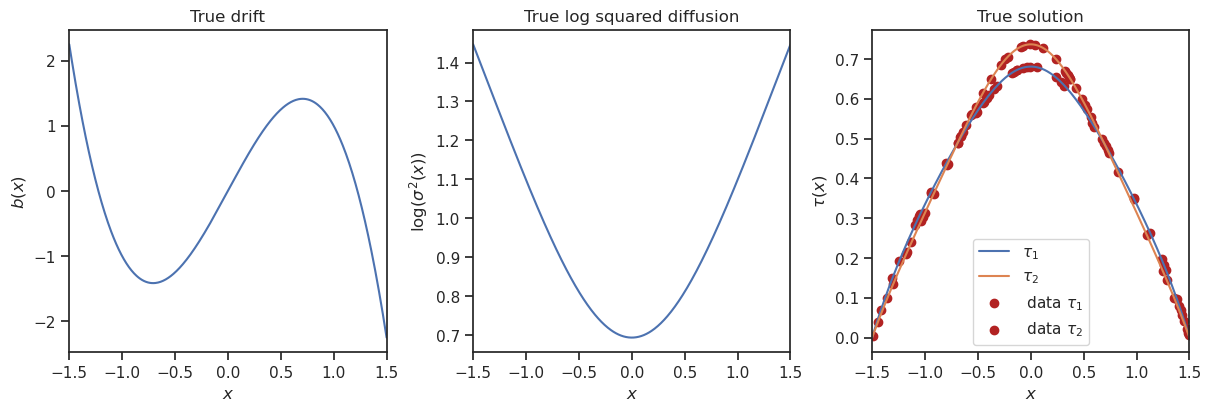

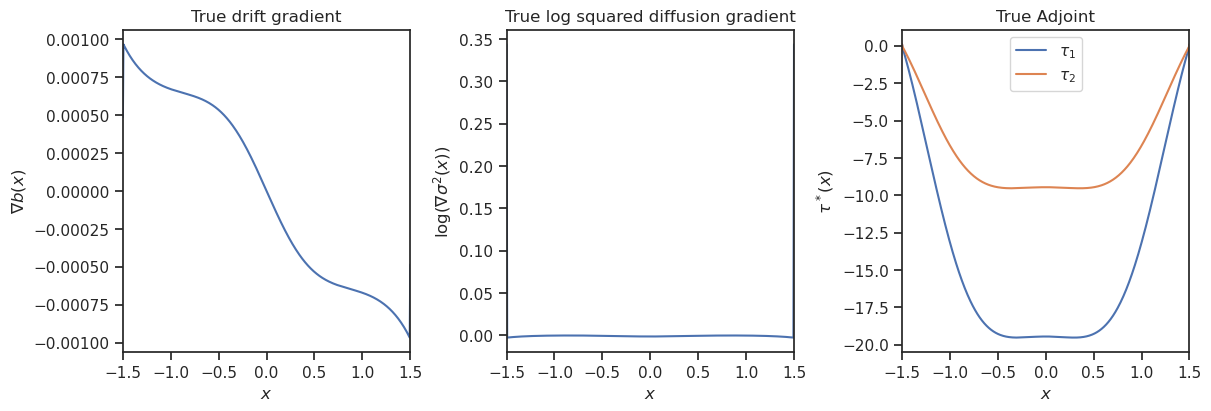

In [15]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
axs[0].plot(parameter_coordinates, true_parameter[0, :])
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[1].plot(parameter_coordinates, true_parameter[1, :])
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True log squared diffusion")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\log(\sigma^2(x))$")
axs[2].plot(solution_coordinates, true_solution[0, :], label=r"$\tau_1$")
axs[2].plot(solution_coordinates, true_solution[1, :], label=r"$\tau_2$")
axs[2].scatter(
    data_locations_mfpt_1, data_values_mfpt_1, color="firebrick", label=r" data $\tau_1$"
)
axs[2].scatter(
    data_locations_mfpt_2, data_values_mfpt_2, color="firebrick", label=r" data $\tau_2$"
)
axs[2].set_xlim(-1.5, 1.5)
axs[2].set_title("True solution")
axs[2].set_xlabel(r"$x$")
axs[2].set_ylabel(r"$\tau(x)$")
axs[2].legend()

_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
axs[0].plot(parameter_coordinates, true_gradient[0, :])
axs[0].set_xlim(-1.5, 1.5)
axs[0].set_title("True drift gradient")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$\nabla b(x)$")
axs[1].plot(parameter_coordinates, true_gradient[1, :])
axs[1].set_xlim(-1.5, 1.5)
axs[1].set_title("True log squared diffusion gradient")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\log(\nabla\sigma^2(x))$")
axs[2].plot(solution_coordinates, true_adjoint[0, :], label=r"$\tau_1$")
axs[2].plot(solution_coordinates, true_adjoint[1, :], label=r"$\tau_2$")
axs[2].set_xlim(-1.5, 1.5)
axs[2].set_title("True Adjoint")
axs[2].set_xlabel(r"$x$")
axs[2].set_ylabel(r"$\tau^*(x)$")
axs[2].legend()

In [5]:
prior_settings = prior.PriorSettings(
    function_space=spin_problem.function_space_parameters,
    mean=("-x[0]", "1"),
    variance=("1", "0.05"),
    correlation_length=("1.5", "1.5"),
    robin_bc=False,
    robin_bc_const=3.0,
)
prior_builder = prior.BilaplacianVectorPriorBuilder(prior_settings)
spin_prior = prior_builder.build()
prior_variance = spin_prior.compute_variance_with_boundaries(
    method="Randomized", num_eigenvalues_randomized=200
)
prior_gradient = spin_prior.evaluate_gradient(true_parameter)

(-1.5, 1.5)

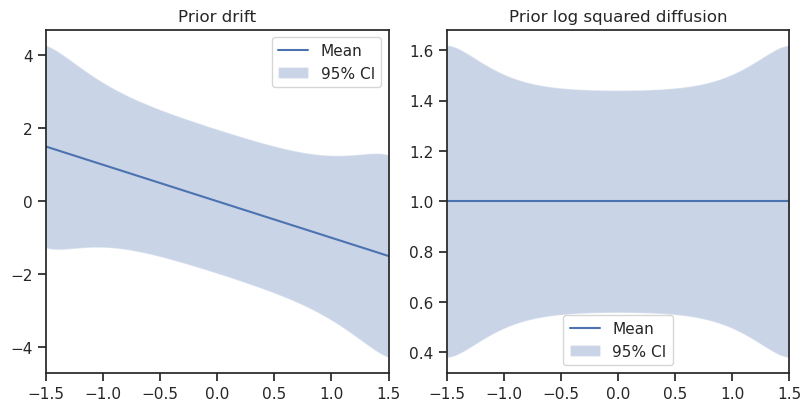

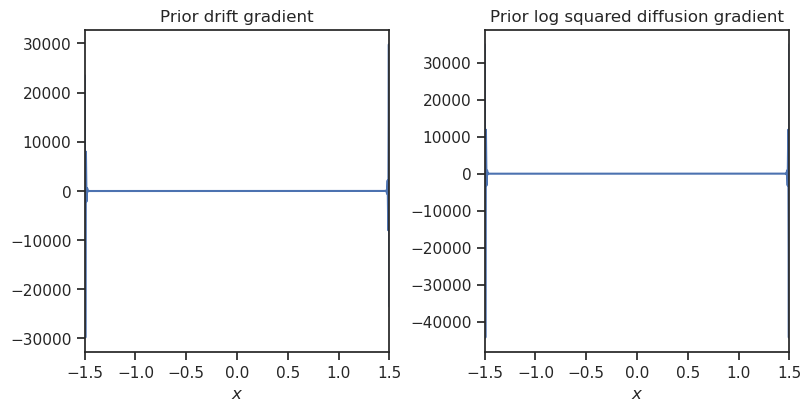

In [6]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(parameter_coordinates, spin_prior.mean_array[0, :], label="Mean")
axs[0].fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array[0, :] - 1.96 * np.sqrt(prior_variance[0, :]),
    spin_prior.mean_array[0, :] + 1.96 * np.sqrt(prior_variance[0, :]),
    alpha=0.3,
    label="95% CI",
)
axs[0].set_title("Prior drift")
axs[0].set_xlim(-1.5, 1.5)
axs[0].legend()

axs[1].plot(parameter_coordinates, spin_prior.mean_array[1, :], label="Mean")
axs[1].fill_between(
    parameter_coordinates.flatten(),
    spin_prior.mean_array[1, :] - 1.96 * np.sqrt(prior_variance[1, :]),
    spin_prior.mean_array[1, :] + 1.96 * np.sqrt(prior_variance[1, :]),
    alpha=0.3,
    label="95% CI",
)
axs[1].set_title("Prior log squared diffusion")
axs[1].set_xlim(-1.5, 1.5)
axs[1].legend()

_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(parameter_coordinates, prior_gradient[0, :])
axs[0].set_title("Prior drift gradient")
axs[0].set_xlabel(r"$x$")
axs[0].set_xlim(-1.5, 1.5)
axs[1].plot(parameter_coordinates, prior_gradient[1, :])
axs[1].set_title("Prior log squared diffusion gradient")
axs[1].set_xlabel(r"$x$")
axs[1].set_xlim(-1.5, 1.5)

In [8]:
misfit_settings = misfit.MisfitSettings(
    function_space=spin_problem.function_space_variables,
    observation_points=(data_locations_mfpt_1, data_locations_mfpt_2),
    observation_values=(data_values_mfpt_1, data_values_mfpt_2),
    noise_variance=2*(noise_std**2 * np.ones(data_locations_mfpt_1.size),),
)
misfit_builder = misfit.MisfitBuilder(misfit_settings)
spin_misfit = misfit_builder.build()

discrepancy_mfpt1 = data_values_mfpt_1 - spin_misfit.observation_matrix[0] @ true_solution[0, :]
discrepancy_mfpt2 = data_values_mfpt_2 - spin_misfit.observation_matrix[1] @ true_solution[1, :]
misfit_grad_mfpt1 = (
    spin_misfit.observation_matrix[0].T @ spin_misfit.noise_precision_matrix[0] @ discrepancy_mfpt1
)
misfit_grad_mfpt2 = (
    spin_misfit.observation_matrix[1].T @ spin_misfit.noise_precision_matrix[1] @ discrepancy_mfpt2
)

In [13]:
true_solution[0, :]

array([0.        , 0.0053035 , 0.01055724, 0.01576224, 0.02091951,
       0.02603001, 0.03109469, 0.03611449, 0.0410903 , 0.04602303,
       0.05091353, 0.05576265, 0.06057123, 0.06534007, 0.07006997,
       0.07476171, 0.07941603, 0.08403368, 0.08861539, 0.09316186,
       0.09767379, 0.10215186, 0.10659673, 0.11100906, 0.11538946,
       0.11973858, 0.12405701, 0.12834535, 0.13260418, 0.13683408,
       0.14103559, 0.14520927, 0.14935566, 0.15347526, 0.15756861,
       0.16163618, 0.16567849, 0.16969599, 0.17368918, 0.17765849,
       0.18160439, 0.18552732, 0.1894277 , 0.19330595, 0.1971625 ,
       0.20099773, 0.20481206, 0.20860586, 0.21237951, 0.21613339,
       0.21986785, 0.22358325, 0.22727994, 0.23095825, 0.23461852,
       0.23826106, 0.24188621, 0.24549426, 0.24908553, 0.2526603 ,
       0.25621886, 0.2597615 , 0.2632885 , 0.26680012, 0.27029662,
       0.27377827, 0.27724532, 0.280698  , 0.28413656, 0.28756122,
       0.29097223, 0.29436979, 0.29775412, 0.30112543, 0.30448

Text(0.5, 0, '$x$')

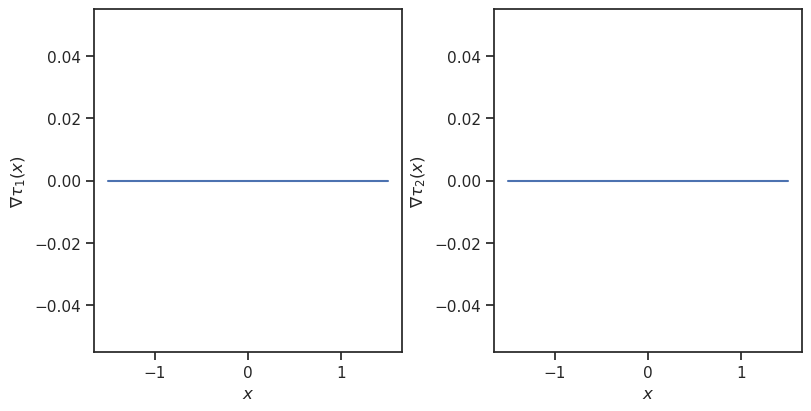

In [9]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout="constrained")
axs[0].plot(solution_coordinates, misfit_grad_mfpt1)
axs[0].set_ylabel(r"$\nabla\tau_1(x)$")
axs[0].set_xlabel(r"$x$")
axs[1].plot(solution_coordinates, misfit_grad_mfpt2)
axs[1].set_ylabel(r"$\nabla\tau_2(x)$")
axs[1].set_xlabel(r"$x$")

In [ ]:
inference_model = hl.Model(
    spin_problem.hippylib_variational_problem,
    spin_prior.hippylib_prior,
    spin_misfit.hippylib_misfit,
)

In [ ]:
optimization_settings = optimization.SolverSettings(
    relative_tolerance=1e-8,
    absolute_tolerance=1e-12,
    max_num_line_search_iterations=10,
    armijo_line_search_constant=1e-4,
    verbose=True,
)
initial_guess = spin_prior.mean_array
newton_solver = optimization.NewtonCGSolver(optimization_settings, inference_model)
solver_solution = newton_solver.solve(initial_guess)
print("Termination reason:", solver_solution.termination_reason)

In [ ]:
hessian_settings = hessian.LowRankHessianSettings(
    num_eigenvalues=30,
    num_oversampling=30,
    inference_model=inference_model,
    evaluation_point=[
        solver_solution.forward_solution,
        solver_solution.optimal_parameter,
        solver_solution.adjoint_solution,
    ],
)
eigenvalues, eigenvectors = hessian.compute_low_rank_hessian(hessian_settings)

In [ ]:
index_vector = np.arange(1, eigenvalues.size + 1)
_, ax = plt.subplots(figsize=(4, 4), layout="constrained")
ax.semilogy(index_vector, eigenvalues, marker="o")
ax.set_title("Eigenvalues")
ax.set_xticks((1, 5, 10, 15, 20, 25, 30))
ax.set_xlabel(r"$i$")
ax.set_ylabel(r"$\lambda_i$")

In [ ]:
laplace_approximation_settings = laplace.LowRankLaplaceApproximationSettings(
    inference_model=inference_model,
    mean=solver_solution.optimal_parameter,
    low_rank_hessian_eigenvalues=eigenvalues,
    low_rank_hessian_eigenvectors=eigenvectors,
)
laplace_approximation = laplace.LowRankLaplaceApproximation(laplace_approximation_settings)
posterior_variance = laplace_approximation.compute_pointwise_variance(
    method="Randomized", num_eigenvalues_randomized=200
)

posterior_predictive = spin_problem.solve_forward(solver_solution.optimal_parameter)

In [ ]:
_, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), layout="constrained")
axs[0].plot(parameter_coordinates, solver_solution.optimal_parameter[0, :], label="Mean")
axs[0].fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter[0, :] - 1.96 * np.sqrt(posterior_variance[0, :]),
    solver_solution.optimal_parameter[0, :] + 1.96 * np.sqrt(posterior_variance[0, :]),
    alpha=0.3,
    label="95% CI",
)
axs[0].set_title("Laplace approximation drift")
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$b(x)$")
axs[0].set_xlim((-1.5, 1.5))
axs[0].legend()

axs[1].plot(parameter_coordinates, solver_solution.optimal_parameter[1, :], label="Mean")
axs[1].fill_between(
    parameter_coordinates.flatten(),
    solver_solution.optimal_parameter[1, :] - 1.96 * np.sqrt(posterior_variance[1, :]),
    solver_solution.optimal_parameter[1, :] + 1.96 * np.sqrt(posterior_variance[1, :]),
    alpha=0.3,
    label="95% CI",
)
axs[1].set_title("Laplace approximation log squared diffusion")
axs[1].set_xlabel(r"$x$")
axs[1].set_ylabel(r"$\log(\sigma^2(x))$")
axs[1].set_xlim((-1.5, 1.5))
axs[1].legend()

axs[2].plot(solution_coordinates, posterior_predictive[0, :], label=r"$\tau_1$")
axs[2].plot(solution_coordinates, posterior_predictive[1, :], label=r"$\tau_2$")
axs[2].scatter(data_locations_mfpt_1, data_values_mfpt_1, color="firebrick", label=r" data $\tau_1$")
axs[2].scatter(data_locations_mfpt_2, data_values_mfpt_2, color="firebrick", label=r" data $\tau_2$")
axs[2].set_xlim(-1.5, 1.5)
axs[2].set_title("True solution")
axs[2].set_xlabel(r"$x$")
axs[2].set_ylabel(r"$\tau(x)$")
axs[2].legend()